In [1]:
import functools
import os

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
from scipy import stats

In [3]:
import matching
import tomography
import weights

In [4]:
os.environ["IMSIM_DATA"] = "/global/cfs/cdirs/desbalro"
os.environ["PATH"] += ":/global/common/software/nersc/pm-2023q2/sw/texlive/2022/bin/x86_64-linux"

In [5]:
# from https://github.com/beckermr/des-y6-analysis/blob/main/2024_10_21_fgmodels/des_y6_nz_modeling.py
def sompz_integral(y, x, low, high):
    low = np.minimum(x[-1], np.maximum(low, x[0]))
    high = np.minimum(x[-1], np.maximum(high, x[0]))
    low_ind = np.digitize(low, x)
    # for the lower index we do not use right=True, but
    # we still want to clip to a valid index of x
    low_ind = np.minimum(low_ind, x.shape[0] - 1)
    high_ind = np.digitize(high, x, right=True)
    dx = x[1:] - x[:-1]

    # high point not in same bin as low point
    not_in_single_bin = high_ind > low_ind

    # fractional bit on the left
    ileft = np.where(
        not_in_single_bin,
        (y[low_ind - 1] + y[low_ind])
        / 2.0
        * (1.0 - (low - x[low_ind - 1]) / dx[low_ind - 1])
        * dx[low_ind - 1],
        (y[low_ind - 1] + y[low_ind]) / 2.0 * (high - low),
    )

    # fractional bit on the right
    iright = np.where(
        not_in_single_bin,
        (y[high_ind - 1] + y[high_ind]) / 2.0 * (high - x[high_ind - 1]),
        0.0,
    )

    # central bits
    yint = (y[1:] + y[:-1]) / 2.0 * dx
    yind = np.arange(yint.shape[0])
    msk = (yind >= low_ind) & (yind < high_ind - 1)
    icen = np.where(
        np.any(msk),
        np.sum(
            np.where(
                msk,
                yint,
                np.zeros_like(yint),
            )
        ),
        0.0,
    )

    return ileft + icen + iright

In [6]:
shear_steps = [
    'g1_slice=-0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=0.6__zhigh=0.9',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=1.8__zhigh=2.1',
    'g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=0.9__zhigh=1.2',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=2.1__zhigh=2.4',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=0.0__zhigh=0.3',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=1.2__zhigh=1.5',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=2.4__zhigh=2.7',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=0.3__zhigh=0.6',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=1.5__zhigh=1.8',
    'g1_slice=0.02__g2_slice=0.00__g1_other=-0.02__g2_other=0.00__zlow=2.7__zhigh=6.0',
]
shear_step_plus = 'g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0'
shear_step_minus = 'g1_slice=-0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0'

In [7]:
tomo_colors = {
    0: "blue",
    1: "gold",
    2: "green",
    3: "red",
}
tomographic_bins = [0, 1, 2, 3]

In [8]:
imsim_base = "/global/cfs/cdirs/des/y6-image-sims/fiducial-400/"
imsim_catalogs = {
    shear_step: os.path.join(
        imsim_base,
        shear_step,
        "metadetect_cutsv6_all.h5",
    )
    for shear_step in shear_steps
}
hf_imsim_dict = {
    shear_step: h5py.File(imsim_catalog, mode="r")
    for shear_step, imsim_catalog in imsim_catalogs.items()
}

In [9]:
redshift_base = "/global/cfs/cdirs/des/y6-redshift/imsim_400Tile/fidbin_S005/"
redshift_catalogs = {
    shear_step: os.path.join(
        redshift_base,
        f"{shear_step}_sompz_unblind_fidbin.h5"
    )
    for shear_step in shear_steps
}
hf_redshift_dict = {
    shear_step: h5py.File(redshift_catalog, mode="r")
    for shear_step, redshift_catalog in redshift_catalogs.items()
}

In [10]:
hf_match_dict = {
    shear_step: h5py.File(f"match_{shear_step}.hdf5", mode="r")
    for shear_step in shear_steps
}

In [90]:
zbinsc = hf_redshift_dict[shear_step_plus]["sompz"]["pzdata_weighted_S005"]["zbinsc"][:]

zc = np.concatenate([[0.0], zbinsc])

nz_sompz = {}
for tomographic_bin in tomographic_bins:
    _nz_p = hf_redshift_dict[shear_step_plus]["sompz"]["pzdata_weighted_S005"][f"bin{tomographic_bin}"][:]
    _nz_p = np.concatenate([[0.0], _nz_p])
    
    _nz_p = _nz_p / np.asarray(sompz_integral(_nz_p, zc, 0, 6.0))
    
    
    _nz_m = hf_redshift_dict[shear_step_minus]["sompz"]["pzdata_weighted_S005"][f"bin{tomographic_bin}"][:]
    _nz_m = np.concatenate([[0.0], _nz_m])
    
    _nz_m = _nz_m / np.asarray(sompz_integral(_nz_m, zc, 0, 6.0))

    
    nz_sompz[tomographic_bin] = (_nz_p + _nz_m) / 2 
    
nz_sompz[-1] = (nz_sompz[0] + nz_sompz[1] + nz_sompz[2] + nz_sompz[3]) / 4

---

In [152]:
from tomographic_matching import do_nz, ZVALS

In [148]:
nz_truth_plus, z_edges = do_nz(
    hf_imsim_dict[shear_step_plus],
    hf_redshift_dict[shear_step_plus],
    hf_match_dict[shear_step_plus],
)

In [149]:
nz_truth_minus, _ = do_nz(
    hf_imsim_dict[shear_step_minus],
    hf_redshift_dict[shear_step_minus],
    hf_match_dict[shear_step_minus],
)

In [150]:
nz_truth = {}
for tomographic_bin in tomographic_bins:
    nz_truth[tomographic_bin] = (
        nz_truth_plus[tomographic_bin] + nz_truth_minus[tomographic_bin]
    ) / 2

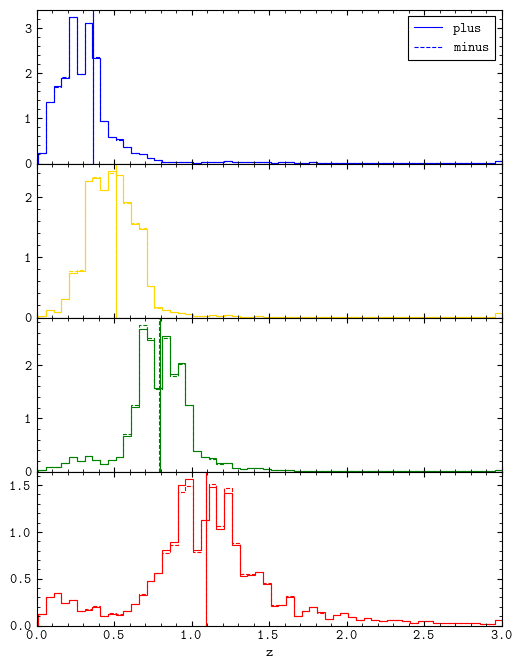

In [151]:
fig, axs = plt.subplots(len(tomographic_bins), 1, figsize=(6, 8), sharex=True, sharey=False)

fig.subplots_adjust(wspace=0, hspace=0)

centers = (z_edges[:-1] + z_edges[1:]) / 2


for i in tomographic_bins:
    axs[i].axvline(
        np.average(centers, weights=nz_truth_plus[i]),
        c=tomo_colors[i],
        label="plus",
    )
    
    axs[i].stairs(nz_truth_plus[i], edges=z_edges, ec=tomo_colors[i])
    
    axs[i].axvline(
        np.average(centers, weights=nz_truth_minus[i]),
        c=tomo_colors[i],
        ls="--",
        label="minus",
    )
    
    axs[i].stairs(nz_truth_minus[i], edges=z_edges, ec=tomo_colors[i], ls="--")
    


axs[-1].set_xlim(0, 3)
axs[-1].set_xlabel("z")
# axs[-1].set_yscale("log")
axs[0].legend()

plt.show()

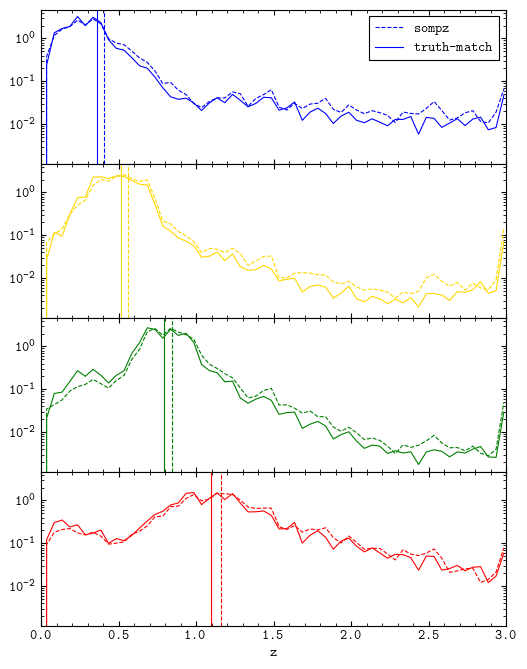

In [153]:
fig, axs = plt.subplots(len(tomographic_bins), 1, figsize=(6, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

# centers = (z_edges[:-1] + z_edges[1:]) / 2
centers = ZVALS

for i in tomographic_bins:
    axs[i].axvline(
        np.average(zc, weights=nz_sompz[i]),
        c=tomo_colors[i],
        ls="--",
        label="sompz",
    )
    axs[i].plot(
        zc,
        nz_sompz[i],
        c=tomo_colors[i],
        ls="--",
    )
    
 
    axs[i].axvline(
        np.average(centers, weights=nz_truth[i]),
        c=tomo_colors[i],
        label="truth-match",
    )
    
    # axs[i].stairs(nz_truth[i], edges=z_edges, ec=tomo_colors[i])
    axs[i].plot(
        centers,
        nz_truth[i],
        c=tomo_colors[i],
    )


axs[-1].set_xlim(0, 3)
axs[-1].set_xlabel("z")
axs[-1].set_yscale("log")
axs[0].legend()

plt.show()

In [161]:
print("b, mean(truth) - mean(sompz)")
for i in tomographic_bins:

    mean_z_truth = np.average(centers, weights=nz_truth[i])
    
    mean_z_sompz = np.average(zc, weights=nz_sompz[i])
    
    print(f"{i}, {mean_z_truth - mean_z_sompz}")

b, mean(truth) - mean(sompz)
0, -0.04042486686363622
1, -0.04632174809750578
2, -0.04784352621746202
3, -0.06420578442549085


In [162]:
print("b, mean(truth) - mean(sompz)")

z = ZVALS
for bi in tomographic_bins:
    z_nz_sompz = sompz_integral(nz_sompz[bi] * z, z, 0.0, 6.0)
    assert np.allclose(sompz_integral(nz_sompz[bi], z, 0.0, 6.0), 1.0)

    nrm = sompz_integral(nz_truth[bi], z, 0.0, 6.0)
    z_nz_truth = sompz_integral(nz_truth[bi] * z, z, 0.0, 6.0) / nrm

    dz = z_nz_truth - z_nz_sompz
    print(f"{bi}, {dz}")

b, mean(truth) - mean(sompz)
0, -0.03970852191697494
1, -0.04201978305069298
2, -0.04687759765300992
3, -0.06324548350912207


In [163]:
print("sompz norm, truth norm")
for bi in tomographic_bins:

    sompz_norm = sompz_integral(nz_sompz[bi], z, 0.0, 6.0)
    truth_norm = sompz_integral(nz_truth[bi], z, 0.0, 6.0)
    print(f"{sompz_norm:10f}, {truth_norm:10f}")

sompz norm, truth norm
  1.000000,   0.991497
  1.000000,   0.997896
  1.000000,   0.998748
  1.000000,   0.996280


In [164]:
print("b, dz")
for bi in range(4):

    sompz_z = sompz_integral(nz_sompz[bi] * z, z, 0.0, 6.0)
    truth_z = sompz_integral(nz_truth[bi] * z, z, 0.0, 6.0)
    print(f"{bi}, {truth_z - sompz_z}")

b, dz
0, -0.042767160050327324
1, -0.04308940063939548
2, -0.047869869733165316
3, -0.06731148167205725


In [186]:
np.savez(
    "nz.npz",
    **{
        "0": nz_truth[0],
        "1": nz_truth[1],
        "2": nz_truth[2],
        "3": nz_truth[3],
    }
)